<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/delivery/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install heartpy
!pip install PyWavelets

In [ ]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from scipy.signal import resample, butter, lfilter, iirnotch
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import pywt as pw
SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [ ]:
#IF run locally
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)


'\n#IF run locally\ndataset_current_folder = "training_set.zip" # where the zip is\ndataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn\'t allow huge uploads\n\nwith zipfile.ZipFile(dataset_current_folder, \'r\') as zip: # extract the zip file into the desired folder \n    zip.extractall(dataset_folder)\n'

In [ ]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = os.path.join(cwd,'training_set_dir')


"\n#IF local runtime used -> Set os.cwd as google drive volume , mounted locally\nos.chdir('G:\\Il mio Drive')\ncwd = os.getcwd()\ncwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')\nos.chdir(cwd)\ndataset_folder = os.path.join(cwd,'training_set_dir')\n"

In [ ]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal


labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████| 105/105 [00:00<00:00, 129.71it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [ ]:
# because of the curse of dimensionality --> undersampling 

from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
ids_250 = df[df['frequencies'] == 250].index.tolist() # 65 signals are sampled using fs = 128
sampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)


100%|██████████| 40/40 [00:15<00:00,  2.59it/s]


<h2>Bandpass filtering

In [ ]:
#Preprocessing used in practical lessons
from scipy.signal import resample, butter, lfilter, iirnotch

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a


def bandpass_filter(data, filter_order=6, lowcut = .8, highcut = 45, signal_freq=128):
    """
    Method responsible for creating and applying Butterworth filter.
    :param deque data: raw data
    :param float lowcut: filter lowcut frequency value
    :param float highcut: filter highcut frequency value
    :param int signal_freq: signal frequency in samples per second (Hz)
    :param int filter_order: filter order
    :return array: filtered data
    """
    powerline = 60
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data,zi = None)
    return y



filtered_df = df.copy(deep= True)

ids = filtered_df.index.tolist()

for id_ in tqdm(ids):
    
    row = filtered_df.iloc[id_]
    first = row['ecg_lead_1']
    second = row['ecg_lead_2']
    filtered_first = np.asarray(bandpass_filter(first))
    filtered_second =  np.asarray(bandpass_filter(second))

    filtered_df.iloc[id_]['ecg_lead_1'] = pd.Series(filtered_first)
    filtered_df.iloc[id_]['ecg_lead_2'] = pd.Series(filtered_second)

100%|██████████| 105/105 [00:04<00:00, 23.06it/s]


['N', 'N', 'S', 'N']


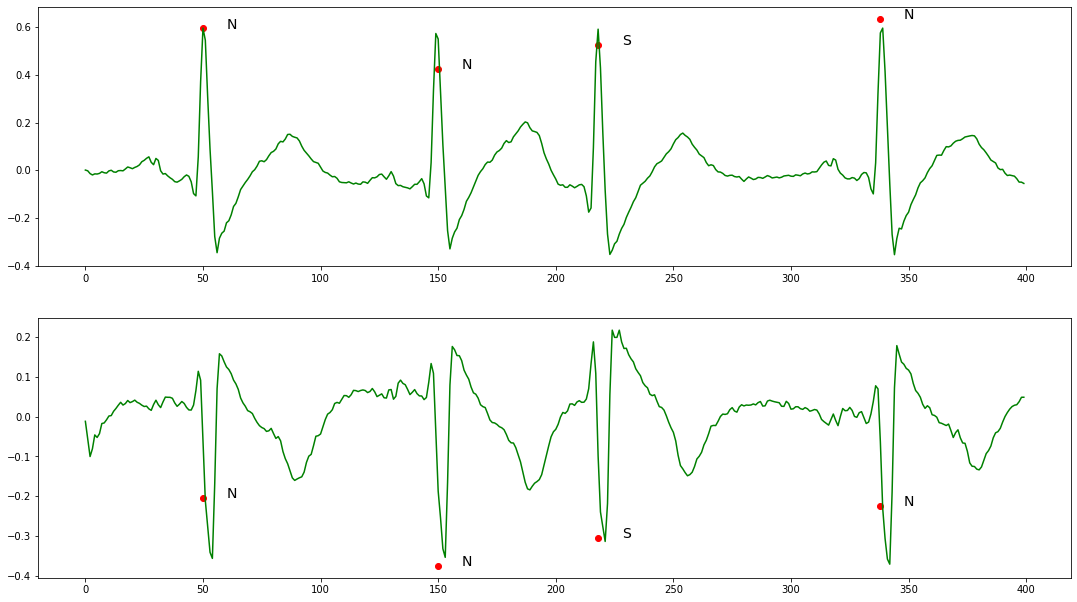

['N', 'N', 'S', 'N']


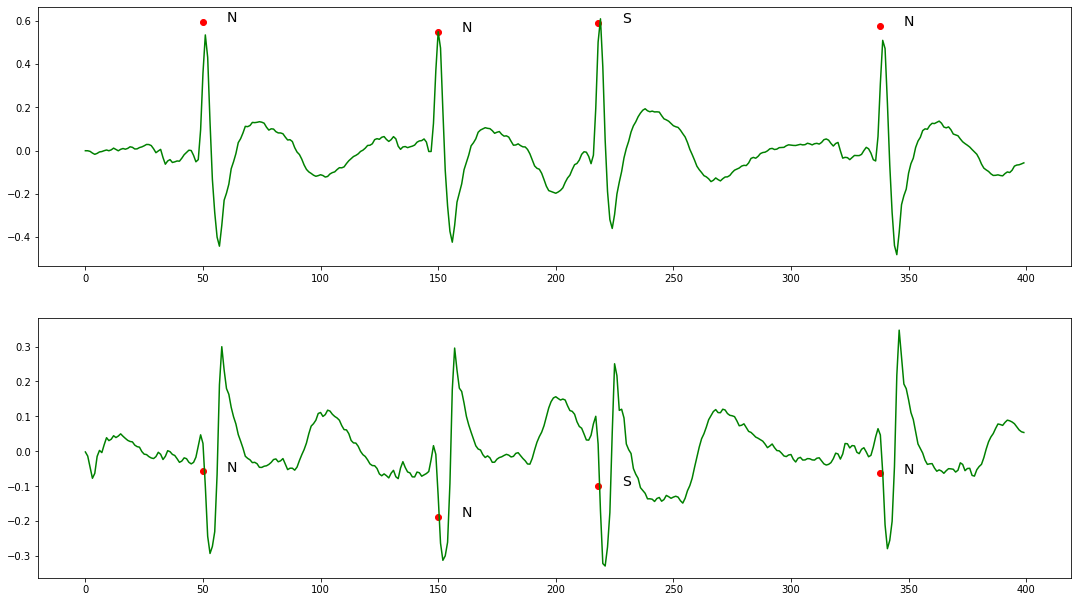

In [ ]:
# plot signal 
from scipy.fft import fft, fftfreq

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
    ax1.plot(x,bandpass_filter(first_lead),color='green')
    ax2.plot(x,bandpass_filter(second_lead),color='green')


    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 10
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()

plot_signal(df,50,400)
plot_signal(filtered_df,50,400)

<h2>Scaling to [0:1] in 10 seconds time window 

In [ ]:
import heartpy as hp

fs = 128
time_window = 10
samples = fs * time_window 

for id in tqdm(filtered_df.index.tolist()):
    row = filtered_df.loc[id]
    first_lead = row['ecg_lead_1']
    second_lead = row['ecg_lead_2']
    l_ = len(first_lead)
    scaled_1 = list()
    scaled_2 = list()
   
    for i in range(int(l_/samples)):
        to_scale_1 = first_lead[i*samples:i*samples+samples] 
        to_scale_2 = second_lead[i*samples:i*samples+samples]
        
        scaled_1 += list(hp.scale_data(to_scale_1,lower=0,upper=1))
        scaled_2 += list(hp.scale_data(to_scale_2,lower=0,upper=1))
    
    filtered_df.loc[id]['ecg_lead_1'] = scaled_1
    filtered_df.loc[id]['ecg_lead_2'] = scaled_2

100%|██████████| 105/105 [01:01<00:00,  1.72it/s]


<h2>Outliers detection and removal using zscore</h2>

In [ ]:
from scipy import stats

# Function for the computation of rhythm data 
def get_2ECG_rhythmfeatures(data):
  
  #   mean
  mean_lead = np.mean(data)

  #   median
  median_lead = np.median(data)

  #   standard deviation
  std_lead = np.std(data)

  #   variance
  var_lead = stats.tvar(data)

  #   Skewness
  skew_lead = stats.skew(data)

  #   Kurtosis
  kurt_lead = stats.kurtosis(data)

  features = np.hstack([mean_lead,median_lead,std_lead,var_lead,skew_lead,kurt_lead])

  return features


features_rhythm_lead1 = list()
features_rhythm_lead2 = list()

for i in range(filtered_df.shape[0]):
  tmp_lead1 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_1'][i])
  features_rhythm_lead1.append(tmp_lead1)
  tmp_lead2 = get_2ECG_rhythmfeatures(filtered_df['ecg_lead_2'][i])
  features_rhythm_lead2.append(tmp_lead2)

features_rhythm_lead1 = pd.DataFrame(features_rhythm_lead1, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1'])
features_rhythm_lead2 = pd.DataFrame(features_rhythm_lead2, columns = ['mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])

features_rhythm = pd.concat([features_rhythm_lead1, features_rhythm_lead2], axis=1)

features = pd.DataFrame(features_rhythm, columns = ['mean_lead1', 'median_lead1', 'std_lead1', 'var_lead1', 'skew_lead1','kurt_lead1',
                                                    'mean_lead2', 'median_lead2', 'std_lead2', 'var_lead2', 'skew_lead2','kurt_lead2'])
display(features) 

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,0.476086,0.474618,0.128357,0.016476,0.065871,3.853435,0.600828,0.613177,0.119664,0.014319,-1.328497,6.504245
1,0.309628,0.315643,0.118704,0.014091,2.242173,11.961672,0.662428,0.672944,0.144363,0.020841,-1.038713,3.939288
2,0.462381,0.466913,0.122431,0.014989,-0.007802,2.618824,0.570732,0.586303,0.134329,0.018044,-0.788964,3.169306
3,0.399816,0.366260,0.149092,0.022228,0.955791,1.976279,0.658729,0.681179,0.162172,0.026300,-1.171663,1.827310
4,0.478230,0.488412,0.131123,0.017193,-0.046548,4.308083,0.555436,0.561574,0.148968,0.022191,-0.156231,1.414820
...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.394100,0.385903,0.132414,0.017534,0.582383,1.942821,0.426588,0.419286,0.116018,0.013460,0.446691,2.379165
101,0.437926,0.430825,0.127339,0.016215,0.479884,3.274700,0.444411,0.452348,0.126760,0.016068,0.327382,3.613294
102,0.345843,0.332378,0.115116,0.013252,1.653328,6.466284,0.403117,0.404505,0.114159,0.013032,0.996624,6.575470
103,0.514950,0.522097,0.098893,0.009780,-0.152302,9.197804,0.461116,0.445006,0.129433,0.016753,0.508997,1.575390


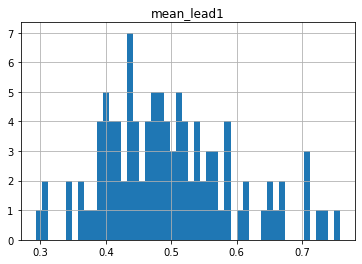

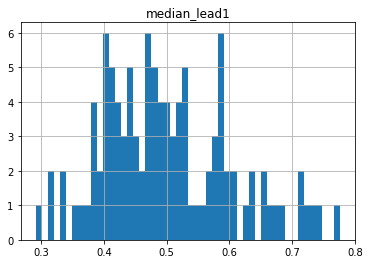

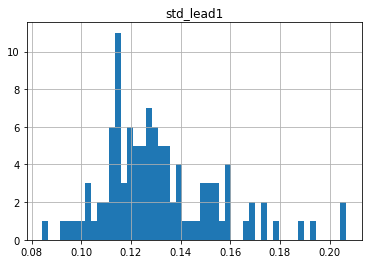

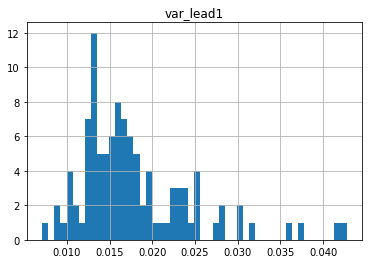

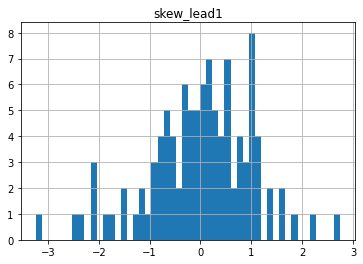

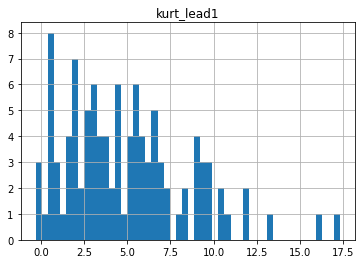

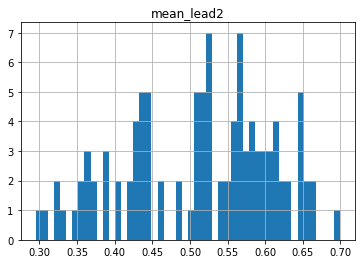

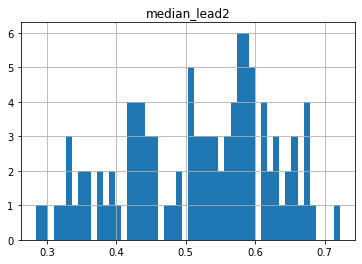

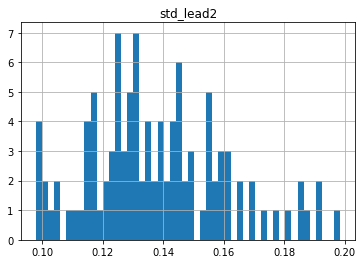

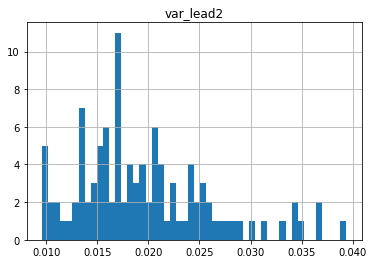

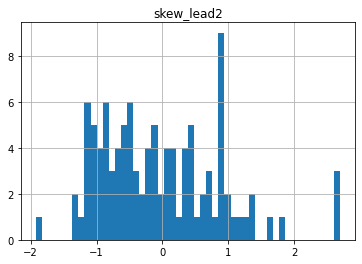

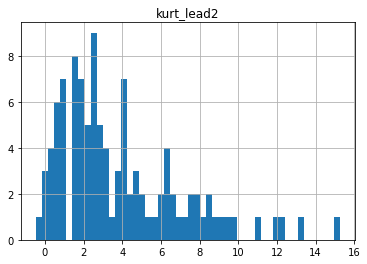

In [ ]:
# Visualize data distribution for each feature
for col in features.columns: 
      features.hist(column = col, bins = 50)

In [ ]:
def plot_outliersAnalysis(abs_zscores):
  # number of outliers per subject 
  bool_zscores = (abs_zscores > 3).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature 
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

Train subjects before outlier removal: (105, 12)
Train subjects after outlier removal: (99, 12)


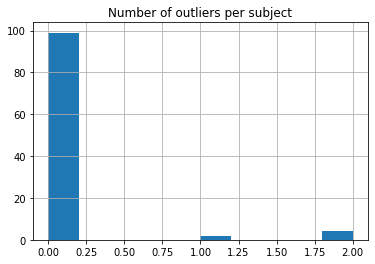

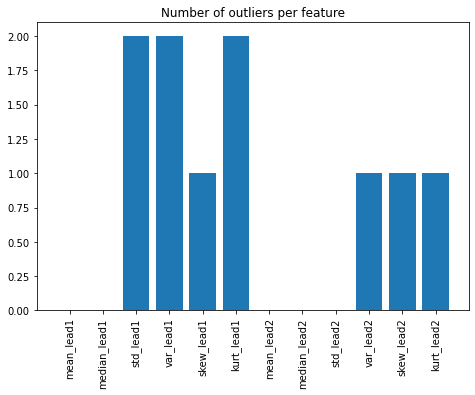

,mean_lead1,median_lead1,std_lead1,var_lead1,skew_lead1,kurt_lead1,mean_lead2,median_lead2,std_lead2,var_lead2,skew_lead2,kurt_lead2
0,0.476086,0.474618,0.128357,0.016476,0.065871,3.853435,0.600828,0.613177,0.119664,0.014319,-1.328497,6.504245
1,0.309628,0.315643,0.118704,0.014091,2.242173,11.961672,0.662428,0.672944,0.144363,0.020841,-1.038713,3.939288
2,0.462381,0.466913,0.122431,0.014989,-0.007802,2.618824,0.570732,0.586303,0.134329,0.018044,-0.788964,3.169306
3,0.399816,0.366260,0.149092,0.022228,0.955791,1.976279,0.658729,0.681179,0.162172,0.026300,-1.171663,1.827310
4,0.478230,0.488412,0.131123,0.017193,-0.046548,4.308083,0.555436,0.561574,0.148968,0.022191,-0.156231,1.414820
...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.394100,0.385903,0.132414,0.017534,0.582383,1.942821,0.426588,0.419286,0.116018,0.013460,0.446691,2.379165
101,0.437926,0.430825,0.127339,0.016215,0.479884,3.274700,0.444411,0.452348,0.126760,0.016068,0.327382,3.613294
102,0.345843,0.332378,0.115116,0.013252,1.653328,6.466284,0.403117,0.404505,0.114159,0.013032,0.996624,6.575470
103,0.514950,0.522097,0.098893,0.009780,-0.152302,9.197804,0.461116,0.445006,0.129433,0.016753,0.508997,1.575390


In [ ]:
# Perform z-scoring for outlier removal
from scipy.stats import zscore
import numpy as np

feature_list = features.columns.tolist()
print('Train subjects before outlier removal: ' + str(features.shape))

# apply zscore
zscore_features = features.apply(zscore, axis=0)

# select all those values with zscore < -+ 3 and discard outliers 
abs_zscores = np.abs(zscore_features)
filtered_entries = (abs_zscores < 3).all(axis=1)

features_or = features[filtered_entries]

print('Train subjects after outlier removal: ' + str(features_or.shape))


plot_outliersAnalysis(abs_zscores)
display(features_or)

In [ ]:
#Discard outliers
filtered_df = filtered_df.loc[features_or.index]
filtered_df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.4276998551489322, 0.4297968302978747, 0.436...","[0.532310106303565, 0.5490810754251085, 0.5625...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[0.30247707914113764, 0.2863248193262056, 0.27...","[0.6568260643541631, 0.6071142459863523, 0.565...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[0.3512323646878618, 0.26321594364695433, 0.19...","[0.5773604271206335, 0.6526769458531666, 0.730...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[0.37546339057539513, 0.30484557586177713, 0.2...","[0.6897625095147278, 0.8119427029099721, 0.919...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[0.44854563084679466, 0.4171212169476861, 0.40...","[0.5060156800184847, 0.49873767797029817, 0.49...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[0.3867161984104746, 0.2355553526715274, 0.137...","[0.39987440384672607, 0.24801773930726578, 0.0...","[79, 196, 312, 427, 539, 652, 766, 880, 992, 1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.5401708356443994, 0.5892531949519814, 0.628...","[0.482446921258743, 0.5604840979852065, 0.6144...","[110, 223, 341, 421, 572, 690, 813, 889, 1041,...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[0.2932188167995345, 0.24850999229693066, 0.21...","[0.40266123819723953, 0.3845442598460282, 0.36...","[130, 273, 418, 559, 705, 848, 990, 1134, 1276...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[0.5088599856075186, 0.510716973774107, 0.4964...","[0.4747395255742389, 0.6609601221105585, 0.677...","[9, 151, 294, 441, 589, 734, 873, 1021, 1160, ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


<h2> RR distances analysis

In [ ]:
signal_ids = filtered_df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()

100%|██████████| 99/99 [00:00<00:00, 230.25it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S114,"[117, 116, 115, 112, 113, 114, 114, 112, 116, ...",[],114.914745,NaN
S115,"[113, 118, 80, 151, 118, 123, 76, 152, 119, 11...",[73],89.041006,73.000000
S116,"[143, 145, 141, 146, 143, 142, 144, 142, 143, ...",[75],122.611082,75.000000
S117,"[142, 143, 147, 148, 145, 139, 148, 139, 140, ...","[119, 99, 92, 100, 99, 92, 91, 92, 89, 87, 82,...",106.363048,83.558719
S118,"[85, 84, 86, 81, 82, 85, 81, 83, 83, 82, 84, 8...",[],93.967755,NaN


In [ ]:
import heartpy as hp 

classes = np.array(["N","S","V"])

patch_length = 350 

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df['sigId']
   
    for id in tqdm(ids):
        row = df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        avg_RR = RR_df.loc[sigId]['Avg_RR_distance'] # T for the signal 

        for i,peak in enumerate(peaks):
            
            stringIdx = str(sigId)+'_'+str(i)    
            dataset_dict[stringIdx] = {}
            dataset_dict[stringIdx]["first_lead"] = list()
            dataset_dict[stringIdx]["second_lead"] = list()
            size = list(range(int(peak-(avg_RR)),int(peak+avg_RR)))

            for s in size:
                if(s < 0 or s >= len(first_lead_signal)):
                    dataset_dict[stringIdx]["first_lead"].append(0.5)
                    dataset_dict[stringIdx]["second_lead"].append(0.5)
                else:
                    dataset_dict[stringIdx]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[stringIdx]["second_lead"].append(second_lead_signal[s])
            
            first_lead = dataset_dict[stringIdx]["first_lead"][:]
            second_lead = dataset_dict[stringIdx]["second_lead"][:]
            
            first_lead = resample(first_lead,patch_length)
            second_lead = resample(second_lead,patch_length)
            
            dataset_dict[stringIdx]["first_lead"] = first_lead[:]
            dataset_dict[stringIdx]["second_lead"] = second_lead[:]
            
            dataset_dict[stringIdx]["stringLabel"] = labels[i]
            dataset_dict[stringIdx]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df

<h2> Split dataset by patient & creation of patches

In [ ]:
training_df, test_df_ = train_test_split(filtered_df,test_size = 0.2,random_state=SEED)
validation_df, test_df = train_test_split(test_df_,test_size = 0.5,random_state=SEED)

training_patches_df_ = create_patch_dataset(training_df)
validation_patches_df_ = create_patch_dataset(validation_df)
test_patches_df = create_patch_dataset(test_df)

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


In [ ]:
validation_patches_df_[(validation_patches_df_['stringLabel']=='S')]

,first_lead,second_lead,stringLabel,label
S005_39,"[0.4463474336263962, 0.4557493391500907, 0.461...","[0.4326370371108029, 0.4289402647396885, 0.449...",S,"[0.0, 1.0, 0.0]"
S005_42,"[0.4692449475206276, 0.44556545258078634, 0.48...","[0.4729538900982039, 0.47205760555841686, 0.49...",S,"[0.0, 1.0, 0.0]"
S005_56,"[0.4621633346927982, 0.4272114754631793, 0.500...","[0.4600667928098441, 0.4741049224285525, 0.438...",S,"[0.0, 1.0, 0.0]"
S005_119,"[0.48021660373305003, 0.5181339555858254, 0.46...","[0.5158287892597505, 0.5316632671367056, 0.526...",S,"[0.0, 1.0, 0.0]"
S005_278,"[0.4906965792794459, 0.4863384727437226, 0.473...","[0.5757272740965887, 0.5820692405648992, 0.578...",S,"[0.0, 1.0, 0.0]"
...,...,...,...,...
S064_3059,"[0.3693840785186533, 0.37151584791021114, 0.37...","[0.5394217494213223, 0.543052483404949, 0.5260...",S,"[0.0, 1.0, 0.0]"
S064_3081,"[0.4230572239043309, 0.4366958716495918, 0.411...","[0.4510251392245645, 0.42712265057551313, 0.44...",S,"[0.0, 1.0, 0.0]"
S064_3082,"[0.44638189159873387, 0.4401345348253622, 0.42...","[0.3790647327767259, 0.342817164539148, 0.3337...",S,"[0.0, 1.0, 0.0]"
S064_3102,"[0.45226238011228737, 0.44918793016293523, 0.4...","[0.4116255847162849, 0.4188745340184911, 0.458...",S,"[0.0, 1.0, 0.0]"


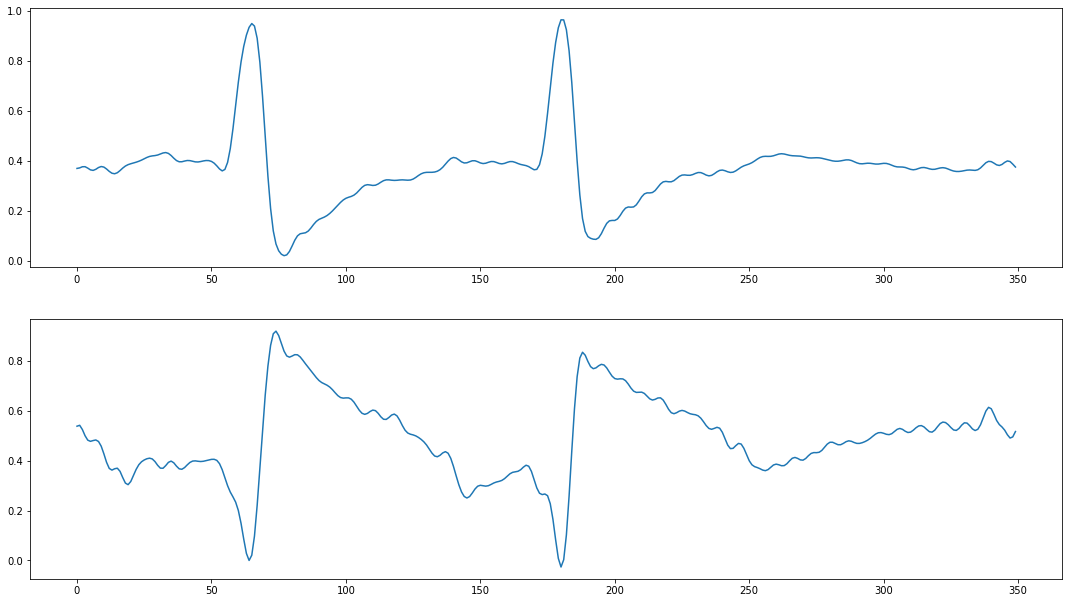

In [ ]:
    signal = validation_patches_df_.loc["S064_3059"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

In [ ]:
validation_patches_df_[(validation_patches_df_['stringLabel']=='V')]

,first_lead,second_lead,stringLabel,label
S028_22,"[0.5067651556531894, 0.5138383442651376, 0.522...","[0.40793282010527804, 0.41054385921702913, 0.4...",V,"[0.0, 0.0, 1.0]"
S028_117,"[0.5442432844786468, 0.550514148720906, 0.5761...","[0.4253274360313075, 0.42934110996140745, 0.42...",V,"[0.0, 0.0, 1.0]"
S028_267,"[0.6271705672202565, 0.6327518889381447, 0.625...","[0.6596580631343364, 0.6580953250805055, 0.658...",V,"[0.0, 0.0, 1.0]"
S028_313,"[0.5651618361532128, 0.5746011639294005, 0.567...","[0.4498977398274356, 0.45669140321091484, 0.44...",V,"[0.0, 0.0, 1.0]"
S028_334,"[0.5294385589017899, 0.5433975763042678, 0.536...","[0.5426718443165235, 0.5440166426426345, 0.551...",V,"[0.0, 0.0, 1.0]"
...,...,...,...,...
S064_3008,"[0.5006293496851453, 0.49226923428529706, 0.50...","[0.3332966872143271, 0.3185728376004523, 0.332...",V,"[0.0, 0.0, 1.0]"
S064_3013,"[0.503653923599582, 0.5165183964353227, 0.5204...","[0.2968394072316792, 0.27981802403945183, 0.26...",V,"[0.0, 0.0, 1.0]"
S064_3091,"[0.47970845507487564, 0.46900455145114267, 0.4...","[0.39239041579390294, 0.37801700705836605, 0.4...",V,"[0.0, 0.0, 1.0]"
S064_3097,"[0.4829838960577496, 0.4731752236148085, 0.475...","[0.33914512911601646, 0.3197216305338219, 0.35...",V,"[0.0, 0.0, 1.0]"


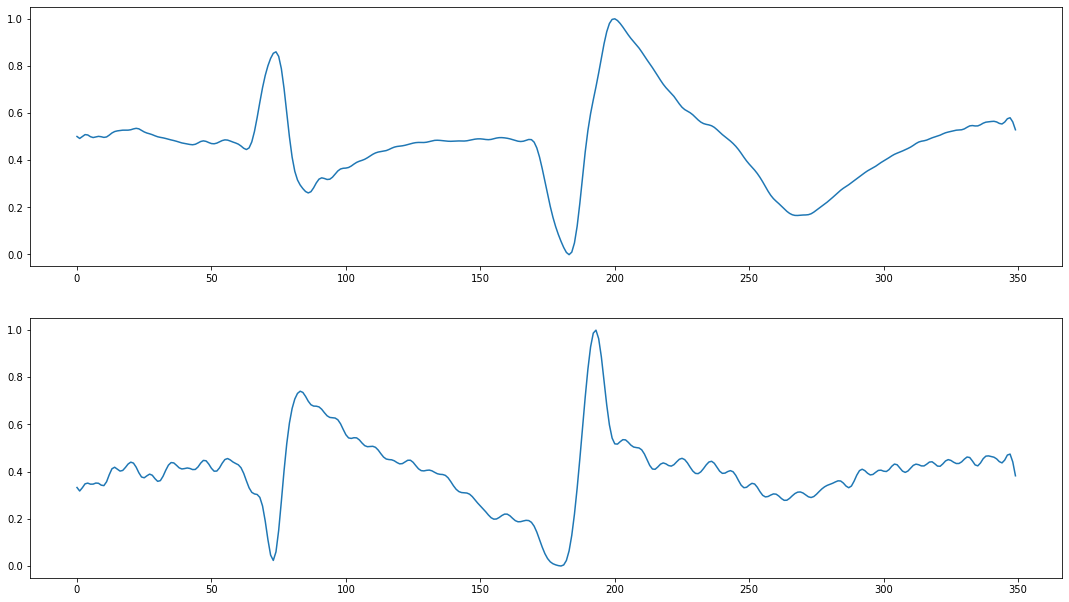

In [ ]:
    signal = validation_patches_df_.loc["S064_3008"]
    length = len(signal['first_lead'])
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax1.plot(x,first_lead)
    ax2.plot(x,second_lead)
    
    plt.show()

<h2> Drop and resampling 

How many training indx: 168940
Balancing training...
pre drop: 181313
post drop:27358
20924
1032
1703
Balancing validation


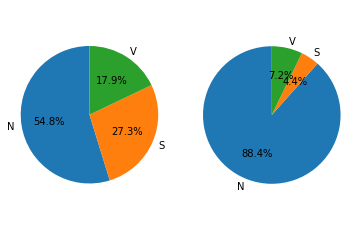

In [ ]:
training_patches_df = training_patches_df_.copy(deep=True)
validation_patches_df = validation_patches_df_.copy(deep=True)

training_df.head()

training_patients = training_df['sigId']
validation_patients = validation_df['sigId']

# calculate percentage of heartbeats to drop 

num_n = len(training_patches_df[(training_patches_df['stringLabel']=='N')])
num_s = len(training_patches_df[(training_patches_df['stringLabel']=='S')])
num_v = len(training_patches_df[(training_patches_df['stringLabel']=='V')])
to_drop = num_n - max(num_s,num_v) * 2
perc_to_drop_train = to_drop/(num_n)


num_n = len(validation_patches_df[(validation_patches_df['stringLabel']=='N')])
num_s = len(validation_patches_df[(validation_patches_df['stringLabel']=='S')])
num_v = len(validation_patches_df[(validation_patches_df['stringLabel']=='V')])
to_drop = 0
perc_to_drop_valid = 0


train_indexes = training_patches_df.index[training_patches_df['stringLabel'] == 'N'].tolist()
valid_indexes = validation_patches_df.index[validation_patches_df['stringLabel'] == 'N'].tolist()

print(f"How many training indx: {len(train_indexes)}")

train_to_drop = list()
valid_to_drop = list()
lengths = list()
dict_train = {}
valid_train = {}

print("Balancing training...")

for p in training_patients:
    dict_train[p] = list()

for hb in train_indexes:
    dict_train[hb.split('_')[0]].append(hb)

for p in dict_train:
   random.shuffle(dict_train[p])

for k in dict_train:
    train_to_drop += dict_train[k][:int(len(dict_train[k]) * perc_to_drop_train)]

print(f"pre drop: {len(training_patches_df.index)}")
training_patches_df = training_patches_df.drop(train_to_drop)
print(f"post drop:{len(training_patches_df.index)}")
print(num_n)
print(num_s)
print(num_v)
print("Balancing validation")

for p in validation_patients:
    valid_train[p] = list()
    
for hb in valid_indexes:
    valid_train[hb.split('_')[0]].append(hb)

for p in valid_train:
    random.shuffle(valid_train[p])

for k in valid_train:
    valid_to_drop += valid_train[k][:int(perc_to_drop_valid * len(valid_train[k]))]

validation_balanced_patches_df = validation_patches_df.drop(valid_to_drop)


training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()


In [ ]:
# resample v and s
from sklearn.utils import shuffle


ids_S = training_patches_df.index[training_patches_df['stringLabel']=='S']
ids_V = training_patches_df.index[training_patches_df['stringLabel']=='V']
ids_N = training_patches_df.index[training_patches_df['stringLabel']=='N']

to_add = {}

to_resample_s = len(ids_N) - len(ids_S)
to_resample_v = len(ids_N) - len(ids_V)

for i in tqdm(range(to_resample_s)):
    id = random.choice(ids_S)
    row = training_patches_df.loc[id]
    idx = id + '_' + str(i)
    to_add[idx] = {}
    to_add[idx]['first_lead'] = row['first_lead']
    to_add[idx]['second_lead'] = row['second_lead']
    to_add[idx]['stringLabel'] = row['stringLabel']
    to_add[idx]['label'] = row['label']



for i in tqdm(range(to_resample_v)):
    id = random.choice(ids_V)
    row = training_patches_df.loc[id]
    idx = id + '_' + str(i)
    to_add[idx] = {}
    to_add[idx]['first_lead'] = row['first_lead']
    to_add[idx]['second_lead'] = row['second_lead']
    to_add[idx]['stringLabel'] = row['stringLabel']
    to_add[idx]['label'] = row['label']


to_add_df = pd.DataFrame.from_dict(to_add,orient="index")
training_patches_df = pd.concat([training_patches_df,to_add_df],axis=0) 
training_patches_df = shuffle(training_patches_df)


100%|██████████| 10085/10085 [00:01<00:00, 5517.66it/s]


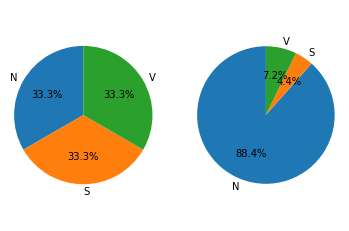

In [ ]:

training_labels = training_patches_df['stringLabel'].values
validation_labels = validation_balanced_patches_df['stringLabel'].values

classes = ["N","S","V"]

training_counts = [0]*3
validation_counts = [0]*3

for l in training_labels:
    training_counts[classes.index(l)] += 1
for l in validation_labels:
    validation_counts[classes.index(l)] += 1

fig1, (ax1,ax2) = plt.subplots(1,2)

ax1.pie(training_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
ax2.pie(validation_counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal')  

fig1.set_facecolor("white")

plt.show()

<h2>Create input

In [ ]:
def create_input(df,step):
    
    x = list()
    y = list()
    
    for id in tqdm(df.index.tolist()):
        row = df.loc[id]
        x.append(np.transpose(np.asarray([row['first_lead'],row['second_lead']]).astype(np.float32)))
        if step == 1:
          y.append(row['stringLabel']!='N')
        elif step == 2:
          y.append(row['stringLabel']!='S')
        else:
          if row['stringLabel'] == 'N':
            y.append(0)
          elif row['stringLabel'] == 'S':
            y.append(1)
          else:
            y.append(2)

    x = np.asarray(x).astype(np.float32)
    y = np.asarray(y).astype(np.float32)
    

    return x,y

In [ ]:
x_train,y_train = create_input(training_patches_df, 1)
x_valid,y_valid = create_input(validation_balanced_patches_df, 1)
x_test,y_test = create_input(test_patches_df,1)

100%|██████████| 24866/24866 [00:05<00:00, 4671.01it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
timesteps = 350 #patch size
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_NvsRest = keras.models.Model(inputs=input, outputs=output)

model_NvsRest.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 128
learning_rate = 1e-5
model_NvsRest.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = y_train, 
                                            y = y_train
                                        )
d_class_weights = dict(enumerate(class_weights))

history = model_NvsRest.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 326, 32)           1632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 163, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 163, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 152, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 76, 64)           0         
 1D)                                                         

In [ ]:
import seaborn as sns 
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=np.squeeze(y_true), predictions=np.rint(np.squeeze(y_pred))).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

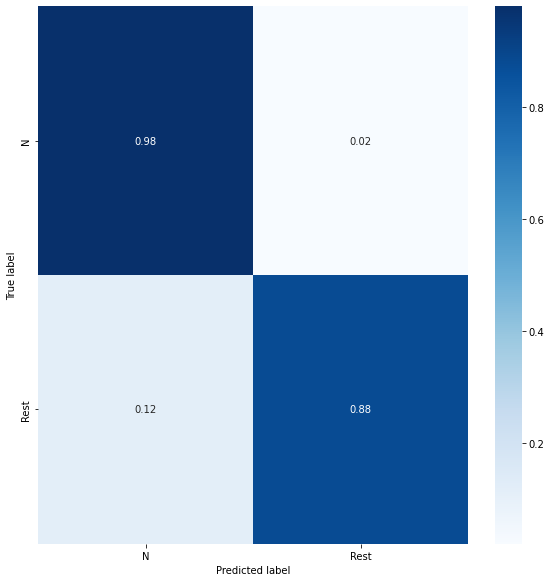

In [ ]:
classes = ['N', 'Rest']
print("Making predictions ...",end="\r")
y_pred= model_NvsRest.predict(x_test)

plot_confusion_matrix(y_test, y_pred)

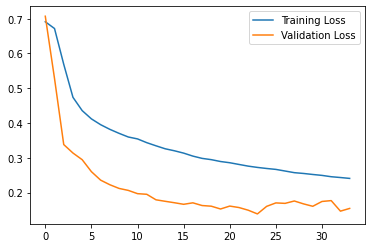

In [ ]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
classes = np.array(["S","V"])
training_patches_df_red = training_patches_df[training_patches_df['stringLabel']!='N']
validation_patches_df_red = validation_balanced_patches_df[validation_balanced_patches_df['stringLabel']!='N']
test_patches_df_red = test_patches_df[test_patches_df['stringLabel']!='N']

In [ ]:
x_train,y_train = create_input(training_patches_df_red, step=2)
x_valid,y_valid = create_input(validation_patches_df_red, step=2)
x_test,y_test = create_input(test_patches_df_red,step=2)

100%|██████████| 1635/1635 [00:00<00:00, 4439.51it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
timesteps = 350 #patch size
channels_num = 2

input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(1, activation=tf.nn.sigmoid)(lstm2)
model_SvsV = keras.models.Model(inputs=input, outputs=output)

model_SvsV.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,mode="auto", restore_best_weights=True)

batch_size = 128
learning_rate = 1e-5
model_SvsV.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'],
    
)

class_weights = compute_class_weight(
                                            class_weight = 'balanced', 
                                            classes = y_train, 
                                            y = y_train
                                        )
d_class_weights = dict(enumerate(class_weights))

history_2 = model_SvsV.fit(
    x = x_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(x_train)/batch_size,
    validation_data=(x_valid, y_valid),
    epochs = 100,
    shuffle = True,
    callbacks=[callback],
    class_weight = d_class_weights
).history


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 350, 2)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 326, 32)           1632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 163, 32)          0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 163, 32)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 152, 64)           24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 76, 64)           0         
 1D)                                                       

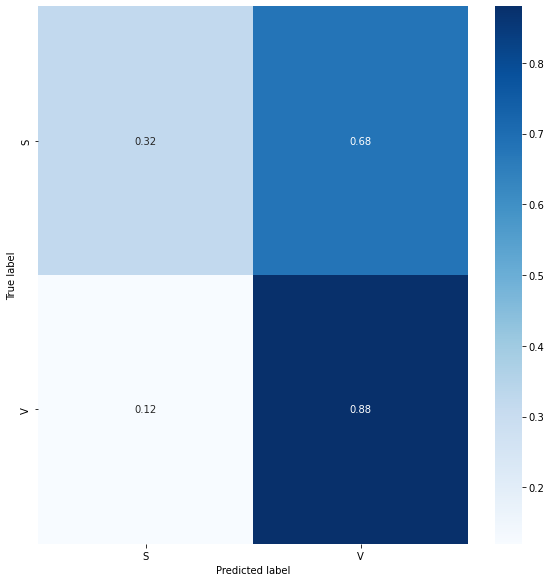

In [ ]:
print("Making predictions ...",end="\r")
y_pred= model_SvsV.predict(x_test)
classes = ['S', 'V']
plot_confusion_matrix(y_test, y_pred)

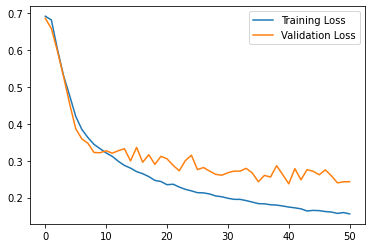

In [ ]:
plt.plot(history_2["loss"], label="Training Loss")
plt.plot(history_2["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

100%|██████████| 23659/23659 [00:05<00:00, 4489.17it/s]


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     20924
         1.0       0.53      0.62      0.57      1032
         2.0       0.76      0.82      0.79      1703

    accuracy                           0.94     23659
   macro avg       0.76      0.80      0.78     23659
weighted avg       0.94      0.94      0.94     23659



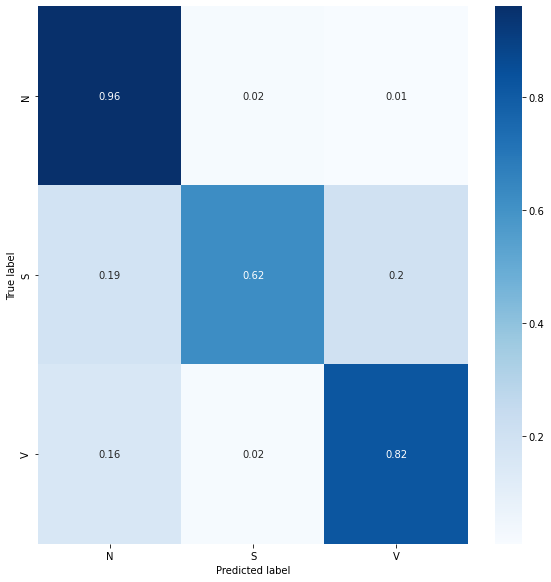

In [ ]:
from sklearn.metrics import classification_report
print("Making predictions on full validation set...",end="\r")
x_valid_full,y_valid_full = create_input(validation_patches_df_, 3)

pred_NvsRest = model_NvsRest.predict(x_valid_full)
pred_fin = np.rint(np.squeeze(pred_NvsRest))

x_valid_full_SvsV = x_valid_full[pred_fin == 1]

y_pred = model_SvsV.predict(x_valid_full_SvsV)
pred_SvsV = np.rint(np.squeeze(y_pred))

k = 0;
for i in range(len(pred_fin)):
  if pred_fin[i] == 1:
    if pred_SvsV[k] == 0:
      pred_fin[i] = 1
    else:
      pred_fin[i] = 2
    k += 1;

classes = ["N","S","V"]
print(classification_report(y_valid_full, pred_fin))    
conf = plot_confusion_matrix(y_valid_full, pred_fin)


<h2> Save and load model

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 
net_name = 'OneVsAll_RVsRest'
# save to csv: 
hist_csv_file = net_name +'_history.csv'
with open(os.path.join(cwd,hist_csv_file), mode='w') as f:
    hist_df.to_csv(f)
model_NvsRest.save_weights(os.path.join(cwd,net_name +'_weights.h5'))
model_NvsRest.save(os.path.join(cwd,net_name))

INFO:tensorflow:Assets written to: /content/drive/My Drive/FinalAssignment/OneVsAll_RVsRest/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/FinalAssignment/OneVsAll_RVsRest/assets


In [ ]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 
net_name = 'OneVsAll_SVsV'
# save to csv: 
hist_csv_file = net_name +'_history.csv'
with open(os.path.join(cwd,hist_csv_file), mode='w') as f:
    hist_df.to_csv(f)
model_SvsV.save_weights(os.path.join(cwd,net_name +'_weights.h5'))
model_SvsV.save(os.path.join(cwd,net_name))

INFO:tensorflow:Assets written to: /content/drive/My Drive/FinalAssignment/OneVsAll_SVsV/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/FinalAssignment/OneVsAll_SVsV/assets
